# SVM (no k-fold)

### Notes
- Nishio et al's "Computer-aided diagnosis of lung nodule using gradient tree boosting and Bayesian optimization"
- https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5908232/
- Uses 64x64x64 images, and LBP-Top for features

# Stratified K-fold cross validation

- https://machinelearningmastery.com/k-fold-cross-validation/
- High variance in my SVM model. Accuracy changes wildly when run multiple times
- insight on repeated k-fold -https://stats.stackexchange.com/questions/218060/does-repeated-k-fold-cross-validation-give-the-same-answers-each-time
- Selecting the best model in scikit-learn using cross validation - https://www.youtube.com/watch?v=6dbrR-WymjI

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
# Retrieve feature dataframe (reduced and normalized) from Feature Extraction and PCA.ipynb
%store -r feat_reduc_df
feat_reduc_df.head()

In [ ]:
# split dataframe into feature and truth label datasets
features = feat_reduc_df[feat_reduc_df.columns[:-1]]
labels = feat_reduc_df['Truth']

# implement stratified k-fold
skf = StratifiedKFold(n_splits=8)
skf.get_n_splits(features, labels)
print(skf)

In [ ]:
clf = svm.SVC(C=1 ,kernel='rbf', probability=True)
clf.fit(features, labels)

In [ ]:
scores = (cross_val_score(clf, X=features, y=labels, cv=8, scoring='accuracy'))
print(scores)

In [ ]:
# average accuracy among k-folds (out-of-sample accuracy)
scores.mean()

In [ ]:
label_score = cross_val_predict(clf, X=features, y=labels, cv=8)
len(label_score)

In [ ]:
fpr, tpr, thresholds = roc_curve(y_true=labels , y_score=label_score)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=0.8)
plt.show()

In [ ]:
print('AUC:', roc_auc_score(y_true=labels , y_score=label_score))

# Stratified K-Fold with ROC and epochs
- http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

In [36]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

In [37]:
# Retrieve feature dataframe (reduced and normalized) from Feature Extraction and PCA.ipynb
%store -r feat_reduc_df
feat_reduc_df.head()

,0,1,2,3,Truth
0,-1.306392,-0.077998,1.397973,1.067861,0
1,-1.265583,-0.119974,1.226719,1.059346,0
2,-0.404961,0.290080,1.318471,-0.849168,0
3,0.132183,-0.547454,0.997631,-0.567614,0
4,0.461200,1.245188,0.238197,-1.528097,0


In [38]:
# split dataframe into feature and truth label datasets
X = feat_reduc_df[feat_reduc_df.columns[:-1]]
y = feat_reduc_df['Truth']

# implement stratified k-fold
skf = StratifiedKFold(n_splits=8)
#skf.get_n_splits(X, y)
#print(skf)

# initialize SVM
clf = svm.SVC(C=1 ,kernel='rbf', probability=True)
print("\n", clf)


 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


In [39]:
auc_list = []

for epoch in range(0, 1000):

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    i = 0
    for train, test in skf.split(X, y):
        probas_ = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
        # Compute ROC curve and AUC
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
#        plt.plot(fpr, tpr, lw=1, alpha=0.3,
#                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        i += 1

#    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
#             label='Chance', alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
#    plt.plot(mean_fpr, mean_tpr, color='b',
#              label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
#              lw=2, alpha=0.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
#    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
#                     label=r'$\pm$ 1 std. dev.')

#    plt.xlim([-0.05, 1.05])
#    plt.ylim([-0.05, 1.05])
#    plt.xlabel('False Positive Rate')
#    plt.ylabel('True Positive Rate')
##   plt.title('Receiver operating characteristic')
#    plt.legend(bbox_to_anchor=(1.1, 1.05))
#    plt.show()
    
    auc_list.append(mean_auc)

average_auc = np.mean(auc_list)
print(average_auc)

0.723024155698398


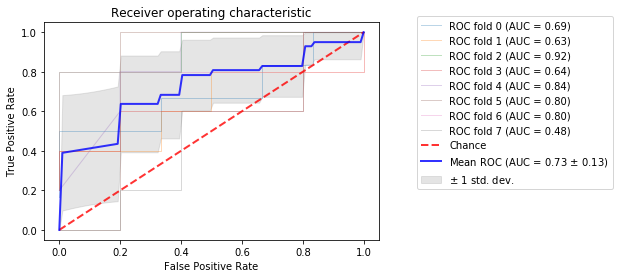

In [20]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

i = 0
for train, test in skf.split(X, y):
    probas_ = clf.fit(X.iloc[train], y.iloc[train]).predict_proba(X.iloc[test])
    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
    tprs.append(interp(mean_fpr, fpr, tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=1, alpha=0.3,
             label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i += 1

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
         label='Chance', alpha=0.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
plt.plot(mean_fpr, mean_tpr, color='b',
          label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
          lw=2, alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2,
                 label=r'$\pm$ 1 std. dev.')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

# Try leave one out cross validation
-good for low dataset counts - https://stats.stackexchange.com/questions/27454/how-does-leave-one-out-cross-validation-work-how-to-select-the-final-model-out

In [ ]:
import pandas as pd
import numpy as np
import sklearn as sk

from sklearn import svm
from sklearn.model_selection import LeaveOneOut, cross_val_score, cross_val_predict, train_test_split
from sklearn.metrics import log_loss, accuracy_score, roc_auc_score

In [ ]:
# Retrieve feature dataframe (reduced and normalized) from Feature Extraction and PCA.ipynb
%store -r feat_reduc_df
feat_reduc_df.head()

In [ ]:
# separate features from truth labels
X = feat_reduc_df[feat_reduc_df.columns[:-1]]
y = feat_reduc_df['Truth']

In [ ]:
# implement leave-one-out
loo = LeaveOneOut()
#folds = loo.split(range(y.size))
folds = loo.split(X)

In [ ]:
folds

In [ ]:
from sklearn import svm

losses = []
accs = []
ys = []
probs = []   

for train_index, test_index in folds:
    X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
            
    clf = svm.SVC(C=1 ,kernel='rbf', probability=True)
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_test)
    
    loss = log_loss(y_test, predictions, labels=[0,1])            
    acc = (y_test == predictions.argmax(axis=1)).sum() 
    losses.append(loss)
    accs.append(acc)

    ys.append(y_test)
    probs.append(predictions[:,1])

In [ ]:
l = np.array(losses).mean()
a = sum(accs)/float(len(y))

probabilities = np.concatenate(probs)
ys = np.concatenate(ys)
auc = roc_auc_score(ys, probabilities)
print("loss=%s, auc=%s, accuracy=%s" % (l, auc, a))